## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code
#### Import Libraries and Modules

In [1]:
import glob
import numpy as np
import scipy as sp
from scipy import io, signal
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Initial Functions

In [2]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

In [3]:
def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

In [4]:
def aggregate_acc(accx, accy, accz):
    """
    Calculate accelerometer magnitude signal from separate channels.

    Args:
        accx: (numpy.ndarray) accelerometer x-channel
        accy: (numpy.ndarray) accelerometer y-channel
        accz: (numpy.ndarray) accelerometer z-channel
    
    Returns:
        acc_mag: (numpy.ndarray) accelerometer magnitude signal
    """
    acc_mag = np.sqrt(np.square(accx) + np.square(accy)+ np.square(accz))
    return acc_mag

In [5]:
def bandpass_filter(sig, order, lower_cutoff_bpm, higher_cutoff_bpm, fs):
    """
    Bandpass filter signal.

    Args:
        sig: (numpy.ndarray) signal to be filtered
        order: (int) filter order
        lower_cutoff_bpm: (float) lower cutoff of the filter in BPM
        higher_cutoff_bpm: (float) higher cutoff of the filter in BPM
        fs: (int) sampling rate in Hz
    
    Returns:
        sig: (numpy.ndarray) filtered signal 
    """
    lower_cutoff_hz = lower_cutoff_bpm / 60
    higher_cutoff_hz = higher_cutoff_bpm / 60
    pass_band = (lower_cutoff_hz, higher_cutoff_hz)
    b, a = sp.signal.butter(order, pass_band, btype='bandpass', fs=fs)
    sig = sp.signal.filtfilt(b, a, sig)
    return sig

In [6]:
def slice_signal(sig, window_len_s, overlap_len_s, fs):
    """
    Divide signal up into slices based on window length and overlap.

    Args:
        sig: (numpy.ndarray) signal to be sliced
        window_len_s: (float) length of window in seconds
        overlap_len_s: (float) length of overlap in seconds
        fs: (int) sampling rate in Hz

    Returns:
        sig_slices: (numpy.ndarray) sliced signal
    """
    window_len_samples = window_len_s * fs
    overlap_len_samples = overlap_len_s * fs
    stride_len_samples = window_len_samples - overlap_len_samples

    sig_slices = []
    first_index = 0
    last_index = window_len_samples

    while last_index < len(sig):
        sig_slices.append(sig[first_index:last_index])
        first_index += stride_len_samples
        last_index += stride_len_samples

    return sig_slices

#### Develop Algorithm and Step Through Example

In [7]:
# Load Data
data_fls, ref_fls = LoadTroikaDataset()
file_num = 0
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[file_num])
ref_bpm = sp.io.loadmat(ref_fls[file_num])['BPM0']

In [8]:
# Aggregate ACC Data
acc_mag = aggregate_acc(accx, accy, accz)

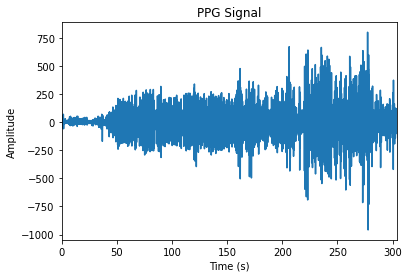

In [9]:
# Filter and Plot PPG Data
order = 5
lower_cutoff_bpm = 40
higher_cutoff_bpm = 240
fs = 125

ppg = bandpass_filter(ppg, order, lower_cutoff_bpm, higher_cutoff_bpm, fs)
sig_duration = len(ppg)/fs
ts = np.arange(0, sig_duration, 1/fs)
plt.plot(ts, ppg)
plt.xlim(0, sig_duration)
plt.title('PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

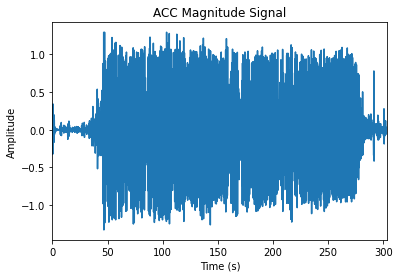

In [10]:
# Filter and Plot ACC Data
acc_mag = bandpass_filter(acc_mag, order, lower_cutoff_bpm, higher_cutoff_bpm, fs)
plt.plot(ts, acc_mag)
plt.xlim(0, sig_duration)
plt.title('ACC Magnitude Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

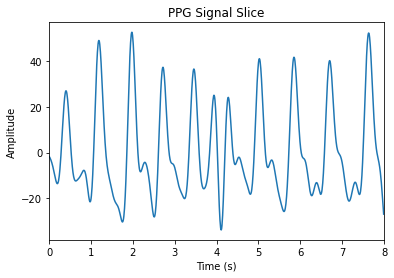

In [11]:
# Slice and Plot PPG Data
window_len_s = 8
overlap_len_s = 6
ppg_slices = slice_signal(ppg, window_len_s, overlap_len_s, fs)
ts = np.arange(0, window_len_s, 1/fs)
slice_num = 3
plt.plot(ts, ppg_slices[slice_num])
plt.xlim([0, window_len_s])
plt.title('PPG Signal Slice')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

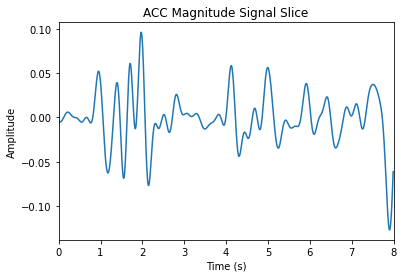

In [12]:
# Slice and Plot ACC Data
acc_mag_slices = slice_signal(acc_mag, window_len_s, overlap_len_s, fs)
plt.plot(ts, acc_mag_slices[slice_num])
plt.xlim([0, window_len_s])
plt.title('ACC Magnitude Signal Slice')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

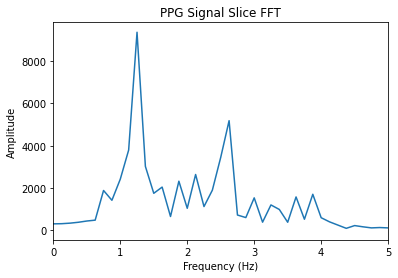

In [13]:
# Calculate and Plot FFT for PPG Data
ppg_freqs = np.fft.rfftfreq(len(ppg_slices[slice_num]), 1/fs)
ppg_fft_mag = np.abs(np.fft.rfft(ppg_slices[slice_num]))
plt.plot(ppg_freqs, ppg_fft_mag)
plt.xlim(0, 5)
plt.title('PPG Signal Slice FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude');

In [14]:
# Determine FFT Peak Locations for PPG Data
max_peak_height = np.amax(ppg_fft_mag)
threshold_peak_percentage = 0.25
threshold_peak_height = threshold_peak_percentage * max_peak_height
ppg_peak_indices = np.where((ppg_fft_mag > threshold_peak_height) == True)[0]
ppg_peak_locations_hz = ppg_freqs[ppg_peak_indices[np.argsort(-ppg_fft_mag[ppg_peak_indices])]][0:4]
print(f"Peak Locations (Hz): {ppg_peak_locations_hz}")
print(f"Peak Locations (BPM): {ppg_peak_locations_hz * 60}")

Peak Locations (Hz): [1.25  2.625 1.125 2.5  ]
Peak Locations (BPM): [ 75.  157.5  67.5 150. ]


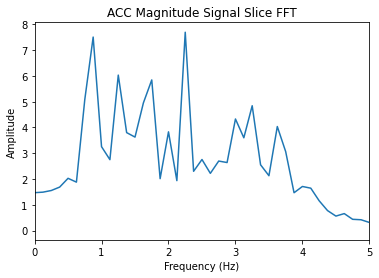

In [15]:
# Calculate and Plot FFT for ACC Data
acc_mag_freqs = np.fft.rfftfreq(len(acc_mag_slices[slice_num]), 1/fs)
acc_mag_fft_mag = np.abs(np.fft.rfft(acc_mag_slices[slice_num]))
plt.plot(acc_mag_freqs, acc_mag_fft_mag)
plt.xlim(0, 5)
plt.title('ACC Magnitude Signal Slice FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude');

In [16]:
# Determine FFT Peak Locations for ACC Data
max_peak_height = np.amax(acc_mag_fft_mag)
threshold_peak_height = threshold_peak_percentage * max_peak_height
acc_mag_peak_indices = signal.find_peaks(acc_mag_fft_mag, height=threshold_peak_height)[0]
acc_mag_peak_locations_hz = acc_mag_freqs[acc_mag_peak_indices[np.argsort(-acc_mag_fft_mag[acc_mag_peak_indices])]][0:2]

# Include Subharmonic(s)
freqs_diff = abs(np.diff(ppg_freqs[0:2]))[0]
acc_fundamental_freq_hz = acc_mag_peak_locations_hz[0]
acc_subharmonic_hz = acc_fundamental_freq_hz/2
acc_subharmonic_mod_hz = np.mod(acc_subharmonic_hz, freqs_diff)

if acc_subharmonic_mod_hz == 0:
    acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 1, acc_subharmonic_hz)
else:
    acc_subharmonics_hz = [acc_subharmonic_hz - np.mod(acc_subharmonic_hz, freqs_diff), acc_subharmonic_hz + np.mod(acc_subharmonic_hz, freqs_diff)]
    acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 1, acc_subharmonics_hz[0])
    acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 2, acc_subharmonics_hz[1])

print(f"Peak Locations (Hz): {acc_mag_peak_locations_hz}")
print(f"Peak Locations (BPM): {acc_mag_peak_locations_hz * 60}")

Peak Locations (Hz): [2.25  1.125 0.875]
Peak Locations (BPM): [135.   67.5  52.5]


In [17]:
# Estimate Heart Rate from PPG Data
ppg_peak_locations_hz_temp = np.array([loc for loc in ppg_peak_locations_hz if loc not in acc_mag_peak_locations_hz])
if len(ppg_peak_locations_hz_temp) == 0:
    pass
else:
    ppg_peak_locations_hz = ppg_peak_locations_hz_temp

estimated_pr_hz = ppg_peak_locations_hz[0]
estimated_pr_bpm = estimated_pr_hz * 60
estimated_pr_bpm

75.0

In [18]:
reference_bpm = ref_bpm[slice_num][0]
reference_bpm

74.66814159292035

In [19]:
# Determine Absolute Error
error = np.abs(ref_bpm[slice_num][0] - estimated_pr_bpm)
error

0.3318584070796504

In [20]:
# Determine PPG Signal Power
power_window_len_bpm = 15 # i.e., +/- 7.5 BPM, i.e., the resolution of the FFT
power_window_len_hz = power_window_len_bpm / 60
power_window = (ppg_freqs >= estimated_pr_hz - (power_window_len_hz / 2)) & (ppg_freqs <= estimated_pr_hz + (power_window_len_hz / 2))
ppg_signal_power = np.sum(ppg_fft_mag[power_window])
ppg_signal_power

16187.600773973872

In [21]:
# Determine PPG Noise Power
noise_window = ~power_window
ppg_noise_power = np.sum(ppg_fft_mag[noise_window])
ppg_noise_power

53389.87798843756

In [22]:
# Determine PPG SNR
ppg_snr = ppg_signal_power / ppg_noise_power
ppg_snr

0.3031960623225166

In [23]:
# Determine Confidence Score
confidence = ppg_snr
confidence

0.3031960623225166

#### Define Remaining Functions and Evaluate

In [24]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Run pulse rate algorithm

    Args:
        data_fl: (str) data file location
        ref_fl: (str) reference file location

    Returns:
        errors: (numpy.ndarray) absolute error for each slice
        confidence: (numpy.ndarray) confidence for each slice

    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Load Reference
    ref_bpm = sp.io.loadmat(ref_fl)['BPM0']

    # Aggregate ACC Data
    acc_mag = aggregate_acc(accx, accy, accz)

    # Filter Data
    order = 5
    lower_cutoff_bpm = 40
    higher_cutoff_bpm = 240
    fs = 125

    ppg = bandpass_filter(ppg, order, lower_cutoff_bpm, higher_cutoff_bpm, fs)   
    acc_mag = bandpass_filter(acc_mag, order, lower_cutoff_bpm, higher_cutoff_bpm, fs)

    # Slice Data
    window_len_s = 8
    overlap_len_s = 6

    ppg_slices = slice_signal(ppg, window_len_s, overlap_len_s, fs)
    acc_mag_slices = slice_signal(acc_mag, window_len_s, overlap_len_s, fs)

    # Compute pulse rate estimates and estimation confidence.
    errors = np.zeros(len(ppg_slices))
    confidence = np.zeros(len(ppg_slices))
    for slice_num in np.arange(len(ppg_slices)):
        # Calculate FFT for PPG Data
        ppg_freqs = np.fft.rfftfreq(len(ppg_slices[slice_num]), 1/fs)
        ppg_fft_mag = np.abs(np.fft.rfft(ppg_slices[slice_num]))

        # Determine FFT Peak Locations for PPG Data
        max_peak_height = np.amax(ppg_fft_mag)
        threshold_peak_percentage = 0.25
        threshold_peak_height = threshold_peak_percentage * max_peak_height
        ppg_peak_indices = np.where((ppg_fft_mag > threshold_peak_height) == True)[0]
        ppg_peak_locations_hz = ppg_freqs[ppg_peak_indices[np.argsort(-ppg_fft_mag[ppg_peak_indices])]][0:4]

        # Calculate FFT for ACC Data
        acc_mag_freqs = np.fft.rfftfreq(len(acc_mag_slices[slice_num]), 1/fs)
        acc_mag_fft_mag = np.abs(np.fft.rfft(acc_mag_slices[slice_num]))

        # Determine FFT Peak Locations for ACC Data
        max_peak_height = np.amax(acc_mag_fft_mag)
        threshold_peak_height = threshold_peak_percentage * max_peak_height
        acc_mag_peak_indices = signal.find_peaks(acc_mag_fft_mag, height=threshold_peak_height)[0]
        acc_mag_peak_locations_hz = acc_mag_freqs[acc_mag_peak_indices[np.argsort(-acc_mag_fft_mag[acc_mag_peak_indices])]][0:2]

        # Include Subharmonic(s)
        freqs_diff = abs(np.diff(ppg_freqs[0:2]))[0]
        acc_fundamental_freq_hz = acc_mag_peak_locations_hz[0]
        acc_subharmonic_hz = acc_fundamental_freq_hz/2
        acc_subharmonic_mod_hz = np.mod(acc_subharmonic_hz, freqs_diff)

        if acc_subharmonic_mod_hz == 0:
            acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 1, acc_subharmonic_hz)
        else:
            acc_subharmonics_hz = [acc_subharmonic_hz - np.mod(acc_subharmonic_hz, freqs_diff), acc_subharmonic_hz + np.mod(acc_subharmonic_hz, freqs_diff)]
            acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 1, acc_subharmonics_hz[0])
            acc_mag_peak_locations_hz = np.insert(acc_mag_peak_locations_hz, 2, acc_subharmonics_hz[1])

        # Estimate Pulse Rate from PPG Data
        ppg_peak_locations_hz_temp = np.array([loc for loc in ppg_peak_locations_hz if loc not in acc_mag_peak_locations_hz])
        if len(ppg_peak_locations_hz_temp) == 0:
            pass
        else:
            ppg_peak_locations_hz = ppg_peak_locations_hz_temp

        estimated_pr_hz = ppg_peak_locations_hz[0]
        estimated_pr_bpm = estimated_pr_hz * 60
        
        # Determine Absolute Error
        errors[slice_num] = np.abs(ref_bpm[slice_num][0] - estimated_pr_bpm)

        # Determine PPG Signal Power
        power_window_len_bpm = 15 # i.e., +/- 7.5 BPM, i.e., the resolution of the FFT
        power_window_len_hz = power_window_len_bpm / 60
        power_window = (ppg_freqs >= estimated_pr_hz - (power_window_len_hz / 2)) & (ppg_freqs <= estimated_pr_hz + (power_window_len_hz / 2))
        ppg_signal_power = np.sum(ppg_fft_mag[power_window])

        # Determine PPG Noise Power
        noise_window = ~power_window
        ppg_noise_power = np.sum(ppg_fft_mag[noise_window])
        
        # Determine PPG SNR
        ppg_snr = ppg_signal_power / ppg_noise_power

        # Determine Confidence Score
        confidence[slice_num] = ppg_snr

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence

In [25]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

In [26]:
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

In [27]:
aggregate_error = Evaluate()
print(f"Aggregate Error: {aggregate_error:.2f} BPM")

Aggregate Error: 10.95 BPM


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm.
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

- **Code Description**
 - The code is broken up into a number of sections:
    - Import Libraries and Modules: libraries and modules necessary for the proper functioning of this notebook are imported
    - Define Initial Functions: data loading and preparation functions are defined
    - Develop Algorithm and Step Through Example: the development and operation of the algorithm is outlined
    - Define Remaining Functions and Evaluate: algorithm running and evaluation functions are defined
      - RunPulseRateAlgorithm: runs the algorithm on the Troika data and returns the error and confidence values for each slice
      - Evaluate: runs the algorithm on the Troika data and returns an aggregate error metric
- **Data Description**
 - The data is split into two sets of files:
   - the first, named 'DATA_01_TYPE01' or similar, contains a variable 'sig' made up of 6 rows:
     - ECG
     - PPG channel 1
     - PPG channel 2
     - ACC x-axis
     - ACC y-axis
     - ACC z-axis
     only the latter four rows, i.e., PPG channel 2 and the ACC rows are used in this notebook
   - the second, named 'REF_01_TYPE01' or similar, contains a vairable 'BPM0' which contains the calculated ground-truth heart rate in every 8 second window, with a stride of 2 seconds, i.e., a 6 second overlap
 - The 'TYPE' of the data refers to the protocol that the participant followed during recording, i.e.,
   - for 'TYPE01' participants, the running speeds changed as follows: rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)
   - for 'TYPE02' participants, the running speeds changed as follows: rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
- **Algorithm Description**
 - How it works:
   1. The separate ACC channels are aggregated into a single magnitude signal
   2. The PPG and ACC magnitude signals are bandpass filtered between 40 and 240 Hz
   3. The PPG and ACC magnitude signals are sliced using an 8 second moving window and a stride of 2 seconds, i.e., an overlap of 6 seconds
   4. The FFT is calculated for a given PPG slice
   5. The locations of the top-3 values in the FFT greater than 25% of the max peak value are determined -- this is done using np.where instead of signal.find_peaks to account for situations where the peak of interest is partially masked by noise due to the motion of the arm
   6. The FFT is calculated for the ACC magnitude slice
   7. The locations of the top-2 peaks in the FFT greater than 25% of the max peak value are determined and the first subharmonic of the max peak included so that it can be accounted for later
   8. The pulse rate is estimated by taking the largest value pulled from the PPG FFT that is not also one of the values pulled from the ACC magnitude FFT -- otherwise, the largest value pulled from the PPG FFT is chosen
   9. The PPG signal power is determined by summing the FFT values in a 15 bpm window around the estimated pulse rate, i.e., +/- 7.5 bpm -- the resolution of the FFT
   10. The PPG noise power is determined by summing the remaining FFT values
   11. The PPG SNR is determined by dividing the signal power by the noise power
   12. The confidence score is set equal to the PPG SNR
   13. Steps 4-12 are then repeated until pulse rate estimates have been derived for the entire signal
 - Aspects of physiology being taken advantage of:
   - When the ventricles of the heart contract (systole), blood gets pushed to the wrist -- among other places -- resulting in a higher concentration of red blood cells at that location. When the LEDs in a PPG sensor shine typically green light into your skin, much of it is absorbed by the red blood cells
   - A PPG sensor works by first shining typically green light into the skin, where some of it gets absorbed by the red blood cells and the rest gets reflected back to the photodetector
   - When the ventricles of the heart contract (systole), blood gets pushed to the wrist -- among other places -- resulting in a higher concentration of red blood cells at that location and thus more absorption / less reflection of the light, producing a trough in the PPG signal
   - When the ventricles of the heart relax (diastole), blood gets pulled from the wrist -- among other places -- resulting in a lower concentration of red blood cells at that location and thus less absorption / more reflection of the light, producing a peak in the PPG signal
   - The frequency with which these peaks and troughs occur can be used to infer pulse rate
 - Algorithm outputs:
   - estimated_pr_bpm: the estimated pulse rate in BPM, for each slice
   - error: the absolute difference between the estimated and actual pulse rate, for each slice
   - confidence: the estimation confidence for each slice
 - Caveats on algorithm outputs:
   - All three outputs are dependent on how noisy the signal is
 - Common failure modes:
   - When the ACC mag FFT peak is broad, sometimes signal.find_peaks will miss a relevant frequency that's not technically the peak value -- still, using signal.find_peaks outperforms np.where overall
   - Also, using np.where to look for components in the PPG signal and signal.find_peaks to look for components in the ACC magnitude signal can lead to some motion related components being detected by the former but not by the latter, leading the algorithm to assume those components are unique to the PPG signal -- that said, this configuration performs best overall
- **Algorithm Performance**
   - Performance was calculated by finding the mean absolute error (difference) between the estimated pulse rate and reference pulse rate across all slices and files, at 90% availability
   - The algorithm performance achieved here is specific to this dataset and would likely not transfer directly to other datasets without some modifications

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 